[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/grgera/Fre-GAN/blob/main/fregan_experiments.ipynb)

# **Fre-GAN implementation experiments**

В данном ноутбуке я покажу эксперименты, которые я провел c реализацией модели вокодера из статьи [Fre-GAN: Adversarial Frequency-consistent Audio Synthesis](https://arxiv.org/pdf/2106.02297.pdf). 

Пайплайн обучения задачи **TextToSpeech** обычно состоит из двух моделей: акустической (текст -> мел-спектрограмма) и вокодера (мел-спектрограмма -> аудиодорожка). \
В этом опыте была реализована модель вокодера **Fre-GAN** для генерации аудио.

Авторы статьи решили улучшить качество генерации, убрать как можно больше роботизированного звучания и обеспечить сохранение частот. Идея заключалась в улучшении подхода, предложенного в `Mel-Gan` и `HiFi-Gan`. А именно:
* **Generator**:
    * добавить "skip-connections", что помогает генератору получать мелы в разных масштабах на разных шагах.
    * реализовать Upsampling через Nearest Neighbor upsampler, который по словам авторов, смягчает тональные артефакты в отличие от ConvTransposed.
Это позвовляет в процессе обучения сначала фокусироваться на низкие частоты, а затем плавно переходить в высоким.
    * добавить еще один  transposed convolution block, изменить kernel sizes в MRF модуле.
* **Discriminators**:
    *   заменить Average Pooling на дискретное вейвет-преобразование, тем самым сохранив частотные диапазоны, не нарушая теорему Котельникова.

## **1. Подготовка к экспериментам**

Нам понадобится библиотека [PyTorch Wavelets]( https://github.com/fbcotter/pytorch_wavelets) для реализации дискретного вейвлет-преобразования - важной составляющей имплементируемой модели.

In [ ]:
% cd Fre-GAN

In [ ]:
! pip install wandb
! wandb login

In [ ]:
! git clone https://github.com/fbcotter/pytorch_wavelets
! pip install ./pytorch_wavelets/

In [ ]:
! pip install -r ./pytorch_wavelets/tests/requirements.txt
! pytest ./pytorch_wavelets/tests/

In [ ]:
! cd model

Для проведения экспериментов необходимы данные, в этом подходе я решил использовать датасет [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) - набор речевых данных, состоящий из 13 100 коротких аудиоклипов, в которых один выступающий читает отрывки из 7 научно-популярных книг. Каждый аудиофайл представляет собой одноканальный **16-битный** wav с частотой дискретизации **22050 Гц.**


In [ ]:
! wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
! tar -xf LJSpeech-1.1.tar.bz2

# **2. Обучение**

Выполним `preprocess.py`, который распределит все данные по удобным директориям и подготовит мел'ы.

In [ ]:
! python preprocess.py --config config.json

Building data...
  0% 0/13100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)
100% 13100/13100 [03:31<00:00, 61.84it/s]


В условиях предоставленных мне ресурсов (Google Colab) я обучал по 2 эпохи.

In [ ]:
! python train.py --config config.json -n test --training_epochs 2

Training process starts!
wandb: Currently logged in as: gritsay (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.12
wandb: Run data is saved locally in /content/wandb/run-20220407_082322-1d1tvkf1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Fre-GAN
wandb: ⭐️ View project at https://wandb.ai/gritsay/personal%20project
wandb: 🚀 View run at https://wandb.ai/gritsay/personal%20project/runs/1d1tvkf1
Epoch: 1
  0% 0/1637 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)
 30% 499/1637 [25:57<1:00:00,  3.16s/it]step: 500, D_loss: 2.451, G_loss: 44.420, 3.121 sec/step
 56% 923/1637 [48:10<37:27,  3.15s/it]wandb: Network error

Чтобы оценить качество сохраненной модели, необходимо загрузить в директорию `/test` файл формата wav, который затем прогнать через модель.

In [ ]:
! mkdir test

In [ ]:
! python inference.py --config config.json -p ./fg_model/test/fg-3000.pt

  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)
100% 1/1 [00:01<00:00,  1.85s/it]


Послушаем оригинальную дорожку.

In [ ]:
from IPython.display import Audio, display
import torchaudio

wav_path = './test/original.wav'
original_wav, sr = torchaudio.load(wav_path)

display(Audio(original_wav, rate=22050))

Выход вокодера после обучения двух эпох.

In [ ]:
voc_path = './output/generated-0.wav'
voc_wav, sr = torchaudio.load(voc_path)

display(Audio(voc_wav, rate=22050))

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def draw_image(path):
    img1 = mpimg.imread(path)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    ax.axis('off')
    ax.imshow(img1);

Сравним спектрограммы оригинальной дорожки и сгенерированной.

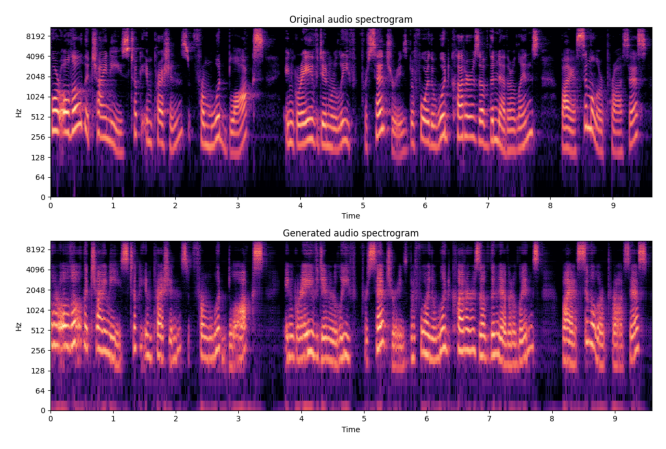

In [ ]:
path = './output/spectrogram-0.png'
draw_image(path)

Спустя время, я попробовал дообучить модель на еще одной эпохе.

In [ ]:
! python train.py --config config.json -n test -p ./fg_model/test/fg-3000.pt --training_epochs 3

In [ ]:
! python inference.py --config config.json -p ./fg_model/test/fg-4000.pt

  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)
100% 1/1 [00:01<00:00,  1.69s/it]


Сгенерированная wav-аудиодорожка после 3 эпох.

In [ ]:
voc_path = './output/generated-0.wav'
voc_wav, sr = torchaudio.load(voc_path)

display(Audio(voc_wav, rate=22050))

Снова взглянем на различие спектрограмм.

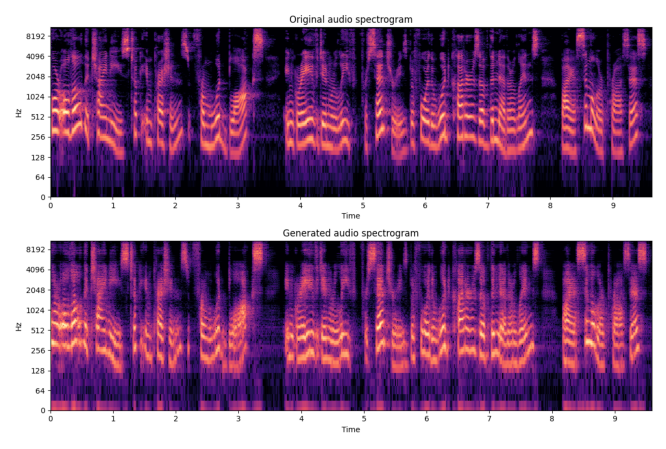

In [ ]:
path = './output/spectrogram-0.png'
draw_image(path)

Был поставлен эксперимент с моделью из статьи с параметрами заданными авторами. После обучения 3! эпох обучения можно слышать тон голоса диктора и корректно различать слова. Единственная проблема, которая осталась - роботозированность. Ее решение - добыть много гпу и оставить на пару часов/дней, со всем остальным должен справиться генератор и вейвлет-преобразование.